# The goal of this document is to:

##  Run CART, random forrest, and logistic regression classification models on bridge only (df) and merged (df2) datasets


In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score
from random import randrange
import warnings
import math
from sklearn import tree
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split #from imblearn import under_sampling, over_sampling

In [10]:
df = pd.read_csv('df.csv')

df['BRIDGE_CONDITION'].unique()
df.groupby(['BRIDGE_CONDITION'])['BRIDGE_CONDITION'].count()

BRIDGE_CONDITION
0    122
1    781
2    391
Name: BRIDGE_CONDITION, dtype: int64

### We were concerned that the relatively low 'poor' condition observations may skew the results of the algorithms; in attempt to address this limitation we attempted to oversample with SMOTE 

In [11]:


y = df.loc[:, df.columns =='BRIDGE_CONDITION']
X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
y.groupby(['BRIDGE_CONDITION'])['BRIDGE_CONDITION'].count()
#our classes should now be balanced between bridge conditions

BRIDGE_CONDITION
0    781
1    781
2    781
Name: BRIDGE_CONDITION, dtype: int64

Text(0, 0.5, 'Frequency')

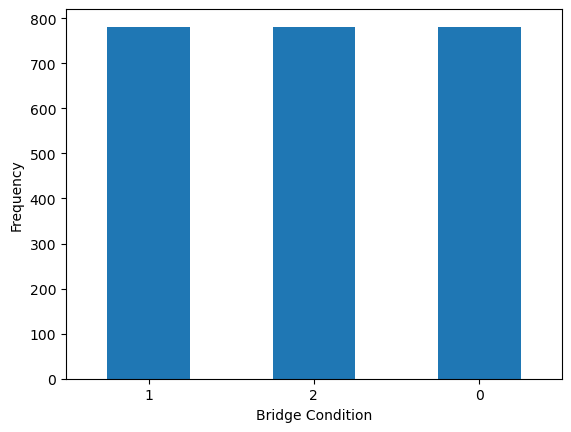

In [12]:
fig = y['BRIDGE_CONDITION'].value_counts().plot.bar(rot=0) #bridges by condition
fig.set_xlabel("Bridge Condition")
fig.set_ylabel("Frequency")

# 3.1 Random Forrest

In [13]:
def evaluate_randomforrest(df):
    y = df.loc[:, df.columns =='BRIDGE_CONDITION']
    X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    columns = X_train.columns
    #oversampling with SMOTE
    oversample = SMOTE()
    os_data_X,os_data_y=oversample.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(data=os_data_X,columns=columns)
    y_train= pd.DataFrame(data=os_data_y,columns=['BRIDGE_CONDITION'])
    gsc = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid={'max_depth': range(2,9),
                                   'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 100],
                                   'min_samples_split': range(2,10)},
                       cv = 5, #Default in function is 5, but kept this line for clarity 
                       scoring = 'accuracy', 
                       verbose = False,                         
                       n_jobs = 1)
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_tree = grid_result.best_estimator_
    plt.figure(figsize=(60,30))
    tree.plot_tree(grid_result.best_estimator_.estimators_[0], 
                   class_names=["Poor", "Fair", "Good"],
                   filled = True, 
                   rounded = True,
                   feature_names = X.columns, 
                   fontsize = 9)
    list_of_tuples = list(zip(X.columns, best_tree.feature_importances_))
    df2 = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Importance'])
    print(df2.nlargest(10, 'Importance')) #Find top 10 features by importance
    model = RandomForestClassifier(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"],
                                min_samples_split=best_params["min_samples_split"],
                                random_state=1, 
                                verbose=False)# K-Fold CV
    print('The best parameters are', best_params, '\n')
    #fit the model
    model.fit(X_train, y_train)
    # make predictions
    yhat1 = model.predict(X_test)
    # evaluate predictions
    accuracy_score_test1 = accuracy_score(y_test, yhat1)
    print('Accuracy score for test data is: %.3f' % accuracy_score_test1)
    yhat2 = model.predict(X_train)
    # evaluate predictions
    accuracy_score_test2 = accuracy_score(y_train, yhat2)
    print('Accuracy score for train data is: %.3f' % accuracy_score_test2)
    # View the classification report for test data and predictions
    print("\nClassification Report: \n \n", classification_report(y_test, yhat1))
    cm_bridge = confusion_matrix(y_test,yhat1)
    #Graphically display confusion matricx
    display_cm_bridge= ConfusionMatrixDisplay(confusion_matrix=cm_bridge, 
                                              display_labels=['Poor (0)',
                                                              'Fair (1)',
                                                             'Good (2)'])
    display_cm_bridge.plot()
    #ROC curve   #Unfortunately was not able to perfect this for 3 classification predictions
 #   y_test_bin = label_binarize(y_test, classes=[0,1,2])
 #   y_score = model.fit(X_train, y_train).predict_proba(X_test)
 #   n_classes = y_test_bin.shape[1]
 #   fpr = dict()
 #   tpr = dict()
 #   roc_auc = dict()
 #   for i in range(n_classes):
 #       fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], yscore[; i])
 #       plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
 #       print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))
 #   plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
 #   plt.xlim([0.0, 1.0])
 #   plt.ylim([0.0, 1.05])
 #   plt.xlabel('False Positive Rate')
 #   plt.ylabel('True Positive Rate')
 #   plt.title('ROC Curves')
 #   plt.show()
    

                      Feature  Importance
14                        Age    0.169200
63    Surface_Type_Bituminous    0.065203
81          Deck_Protect_None    0.056445
1                     ADT_029    0.045444
2            DEGREES_SKEW_034    0.044823
10                  DECK_AREA    0.044196
9       PERCENT_ADT_TRUCK_109    0.043551
19          Maintenance_State    0.042630
78  Deck_Protect_Epoxy Coated    0.039749
6        ROADWAY_WIDTH_MT_051    0.036838
The best parameters are {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 100} 

Accuracy score for test data is: 0.761
Accuracy score for train data is: 0.944

Classification Report: 
 
               precision    recall  f1-score   support

           0       0.56      0.61      0.58        46
           1       0.82      0.78      0.80       237
           2       0.74      0.77      0.76       106

    accuracy                           0.76       389
   macro avg       0.70      0.72      0.71       389
weighted avg     

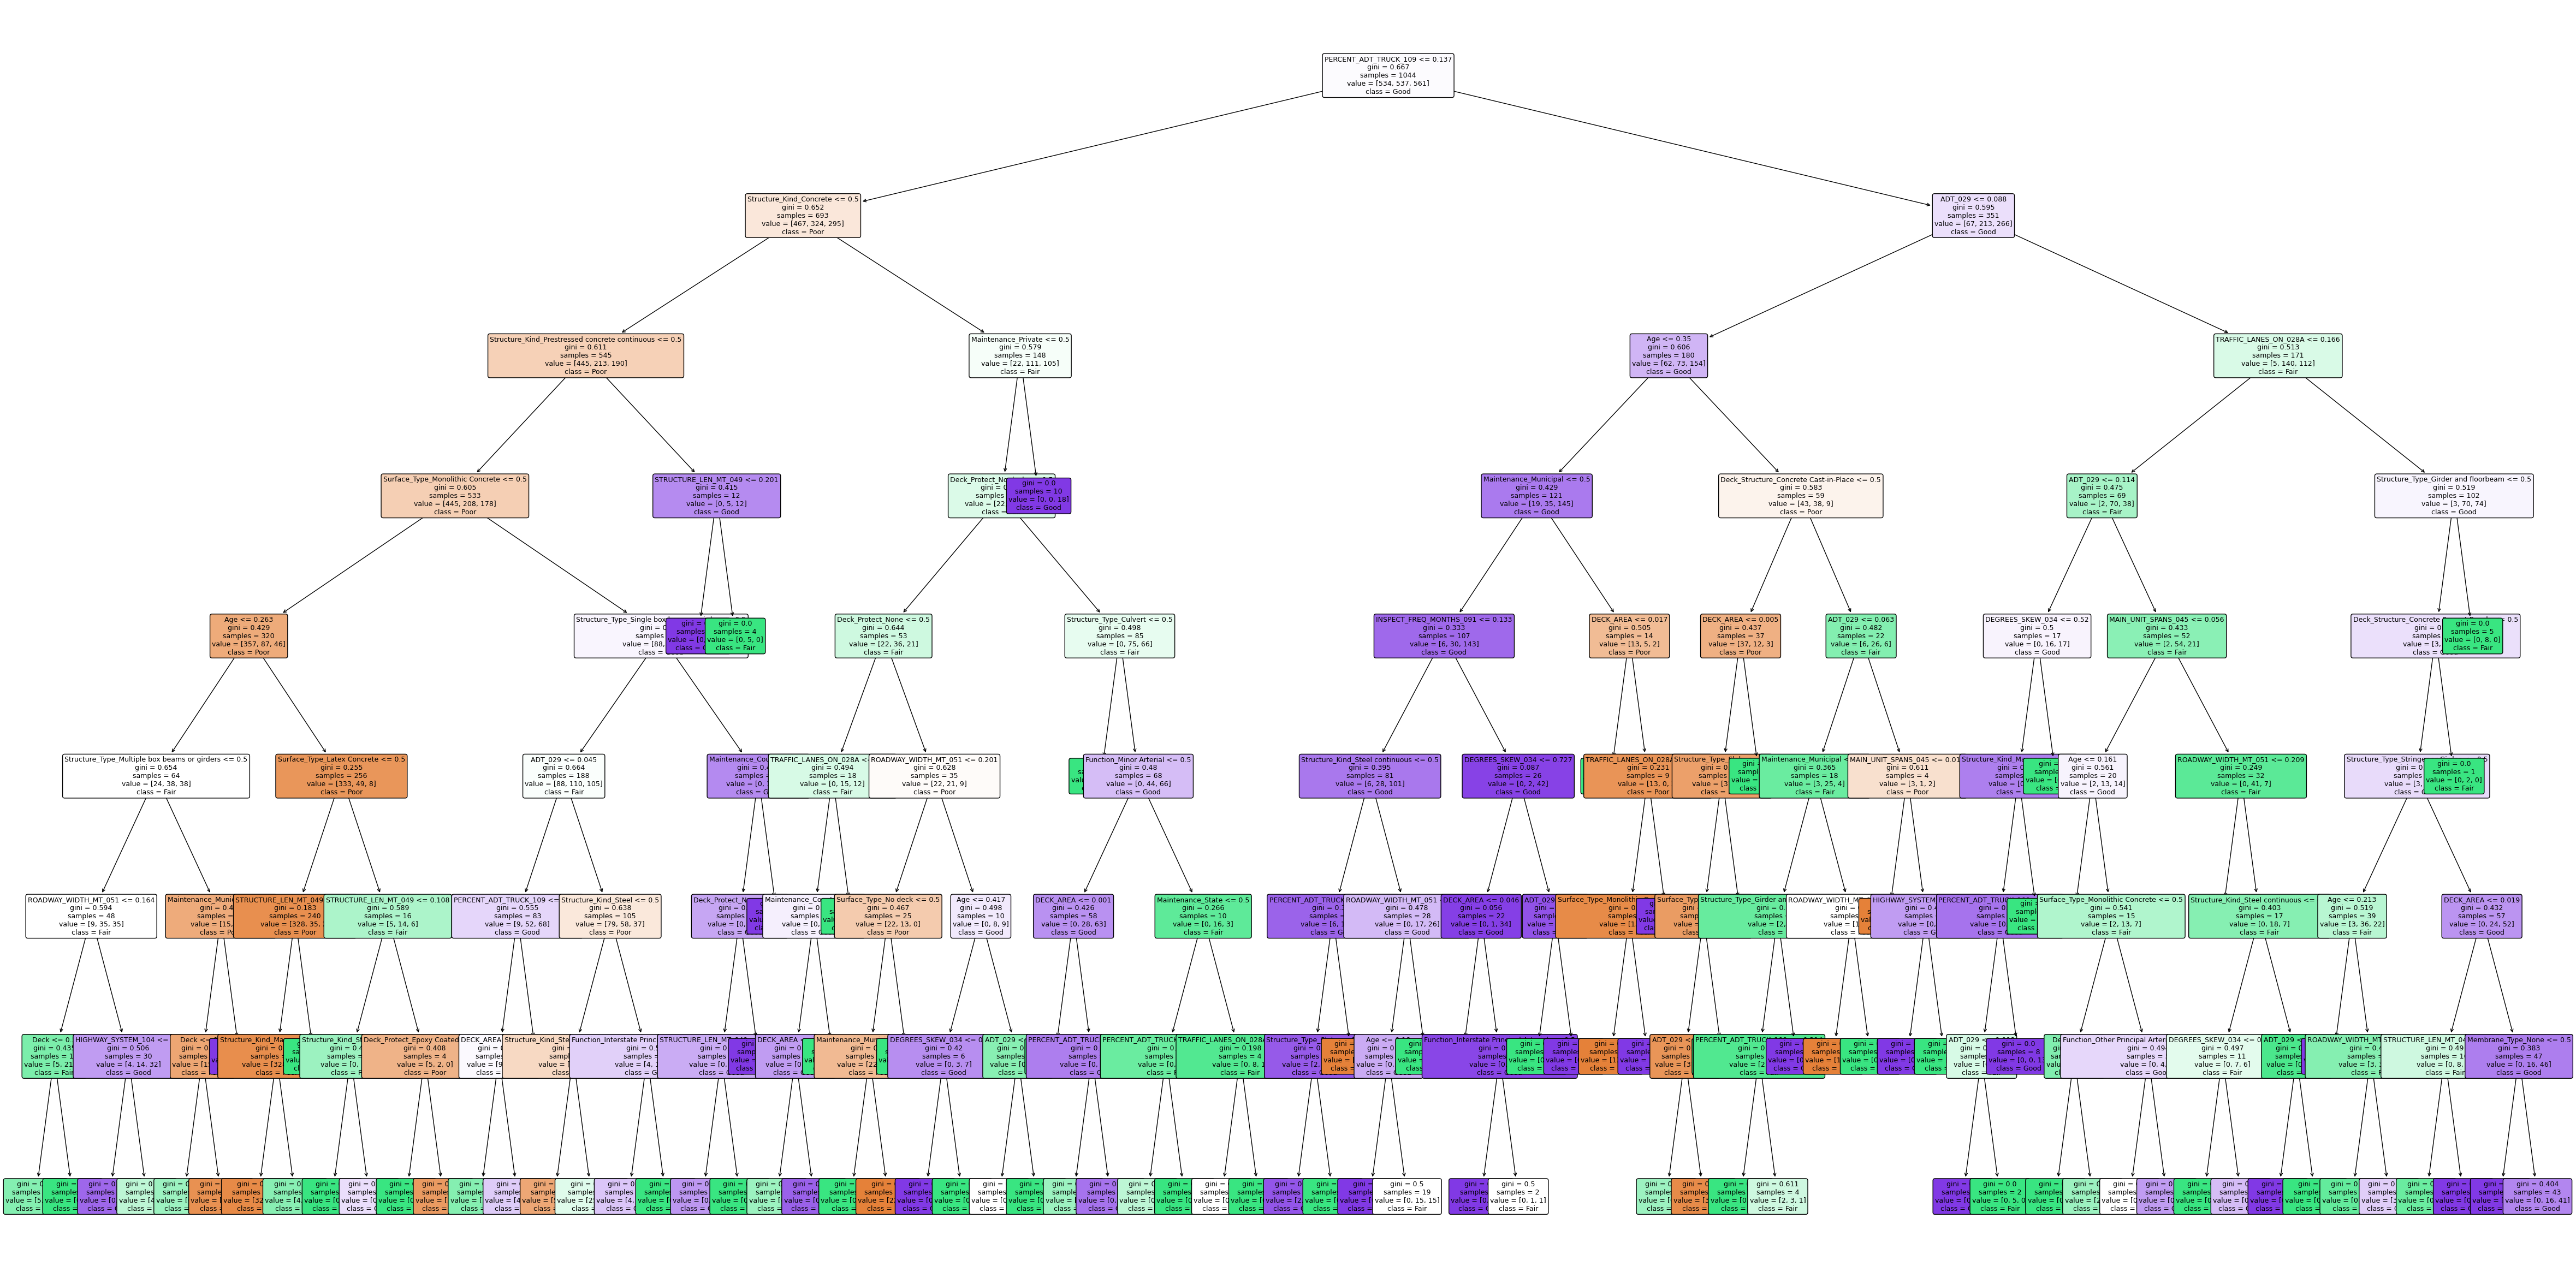

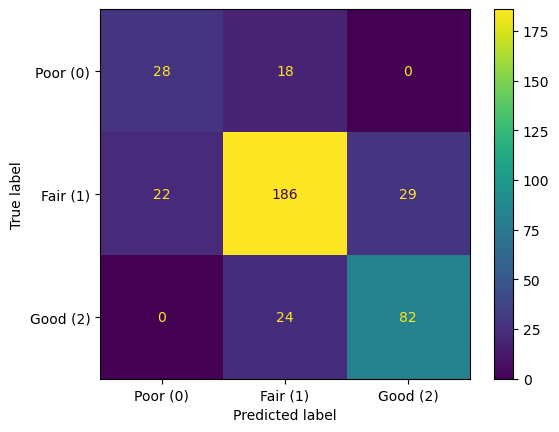

In [14]:
evaluate_randomforrest(df)


# 3.2 CART model

In [15]:
#CART model function takes data, splits into test and train. Oversamples the train data, does hypertuning, 
#Picks the best model according to hypertuning results, then tests. 
def evaluate_CART(df):
    y = df.loc[:, df.columns =='BRIDGE_CONDITION']
    X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    columns = X_train.columns
    #oversampling with SMOTE
    oversample = SMOTE()
    os_data_X,os_data_y=oversample.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(data=os_data_X,columns=columns)
    y_train= pd.DataFrame(data=os_data_y,columns=['BRIDGE_CONDITION'])
    DecisionTree_for_GridSearch = DecisionTreeClassifier(random_state = 5)
    tree_gsearch = GridSearchCV(estimator = DecisionTree_for_GridSearch, 
                     param_grid = {"criterion" : ["gini", "entropy"], #Criterion indicates the function to measure the quality of a split
                                   "max_depth" : range(1,10), #Maximum depth of the tree
                                   "min_samples_leaf" : [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, None], #Minumum per leaf
                                   'min_samples_split': range(2,10)}, #The minimum number of obv per leaf node
                     cv = 5,  #CV will divide data randomly into 5 and cross validate
                     scoring = "accuracy")
    tree_gsearch.fit(X_train, y_train)
    best_params = tree_gsearch.best_params_
    best_score = tree_gsearch.best_score_
    print("The best parameters found are:", best_params, '\n')
    best_tree = tree_gsearch.best_estimator_
    model = DecisionTreeClassifier(random_state = 5,
                                   criterion = best_params['criterion'],
                                   max_depth=best_params["max_depth"], 
                                   min_samples_leaf=best_params["min_samples_leaf"],
                                   min_samples_split=best_params["min_samples_split"])
    list_of_tuples = list(zip(X.columns, best_tree.feature_importances_))
    df2 = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Importance'])
    print(df2.nlargest(10, 'Importance')) #Find top 10 features by importance
    tree_fig = plt.figure(figsize=(60,40))
    _ = tree.plot_tree(decision_tree = best_tree,
                       filled=True,
                       rounded=True,
                       class_names=["Poor", "Fair", "Good"],
                       feature_names = X.columns, 
                       fontsize = 9); 
    _
    #fit the model
    model.fit(X_train, y_train)
    # get accuracy
    accuracy_score_test1 = model.score(X_test, y_test)
    print('Accuracy score for test data is: %.3f' % accuracy_score_test1)
    accuracy_score_test2 = model.score(X_train, y_train)
    print('Accuracy score for train data is: %.3f' % accuracy_score_test2)
    # make predictions
    yhat1 = model.predict(X_test)
    # View the classification report for test data and predictions
    print("\nClassification Report \n", classification_report(y_test, yhat1))
    matrix = confusion_matrix(y_test,yhat1)
    #print( "Confusion Matrix \n", matrix)
    ConfusionMatrixDisplay.from_predictions(y_test, yhat1)

The best parameters found are: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 9} 

                    Feature  Importance
14                      Age    0.324899
19        Maintenance_State    0.132778
81        Deck_Protect_None    0.070949
2          DEGREES_SKEW_034    0.048705
16    Maintenance_Municipal    0.044874
15       Maintenance_County    0.040019
4       MAX_SPAN_LEN_MT_048    0.034673
29  Structure_Kind_Concrete    0.029981
1                   ADT_029    0.029395
9     PERCENT_ADT_TRUCK_109    0.027949
Accuracy score for test data is: 0.656
Accuracy score for train data is: 0.865

Classification Report 
               precision    recall  f1-score   support

           0       0.48      0.57      0.52        46
           1       0.78      0.62      0.69       237
           2       0.55      0.76      0.64       106

    accuracy                           0.66       389
   macro avg       0.61      0.65      0.62       389
weighted avg

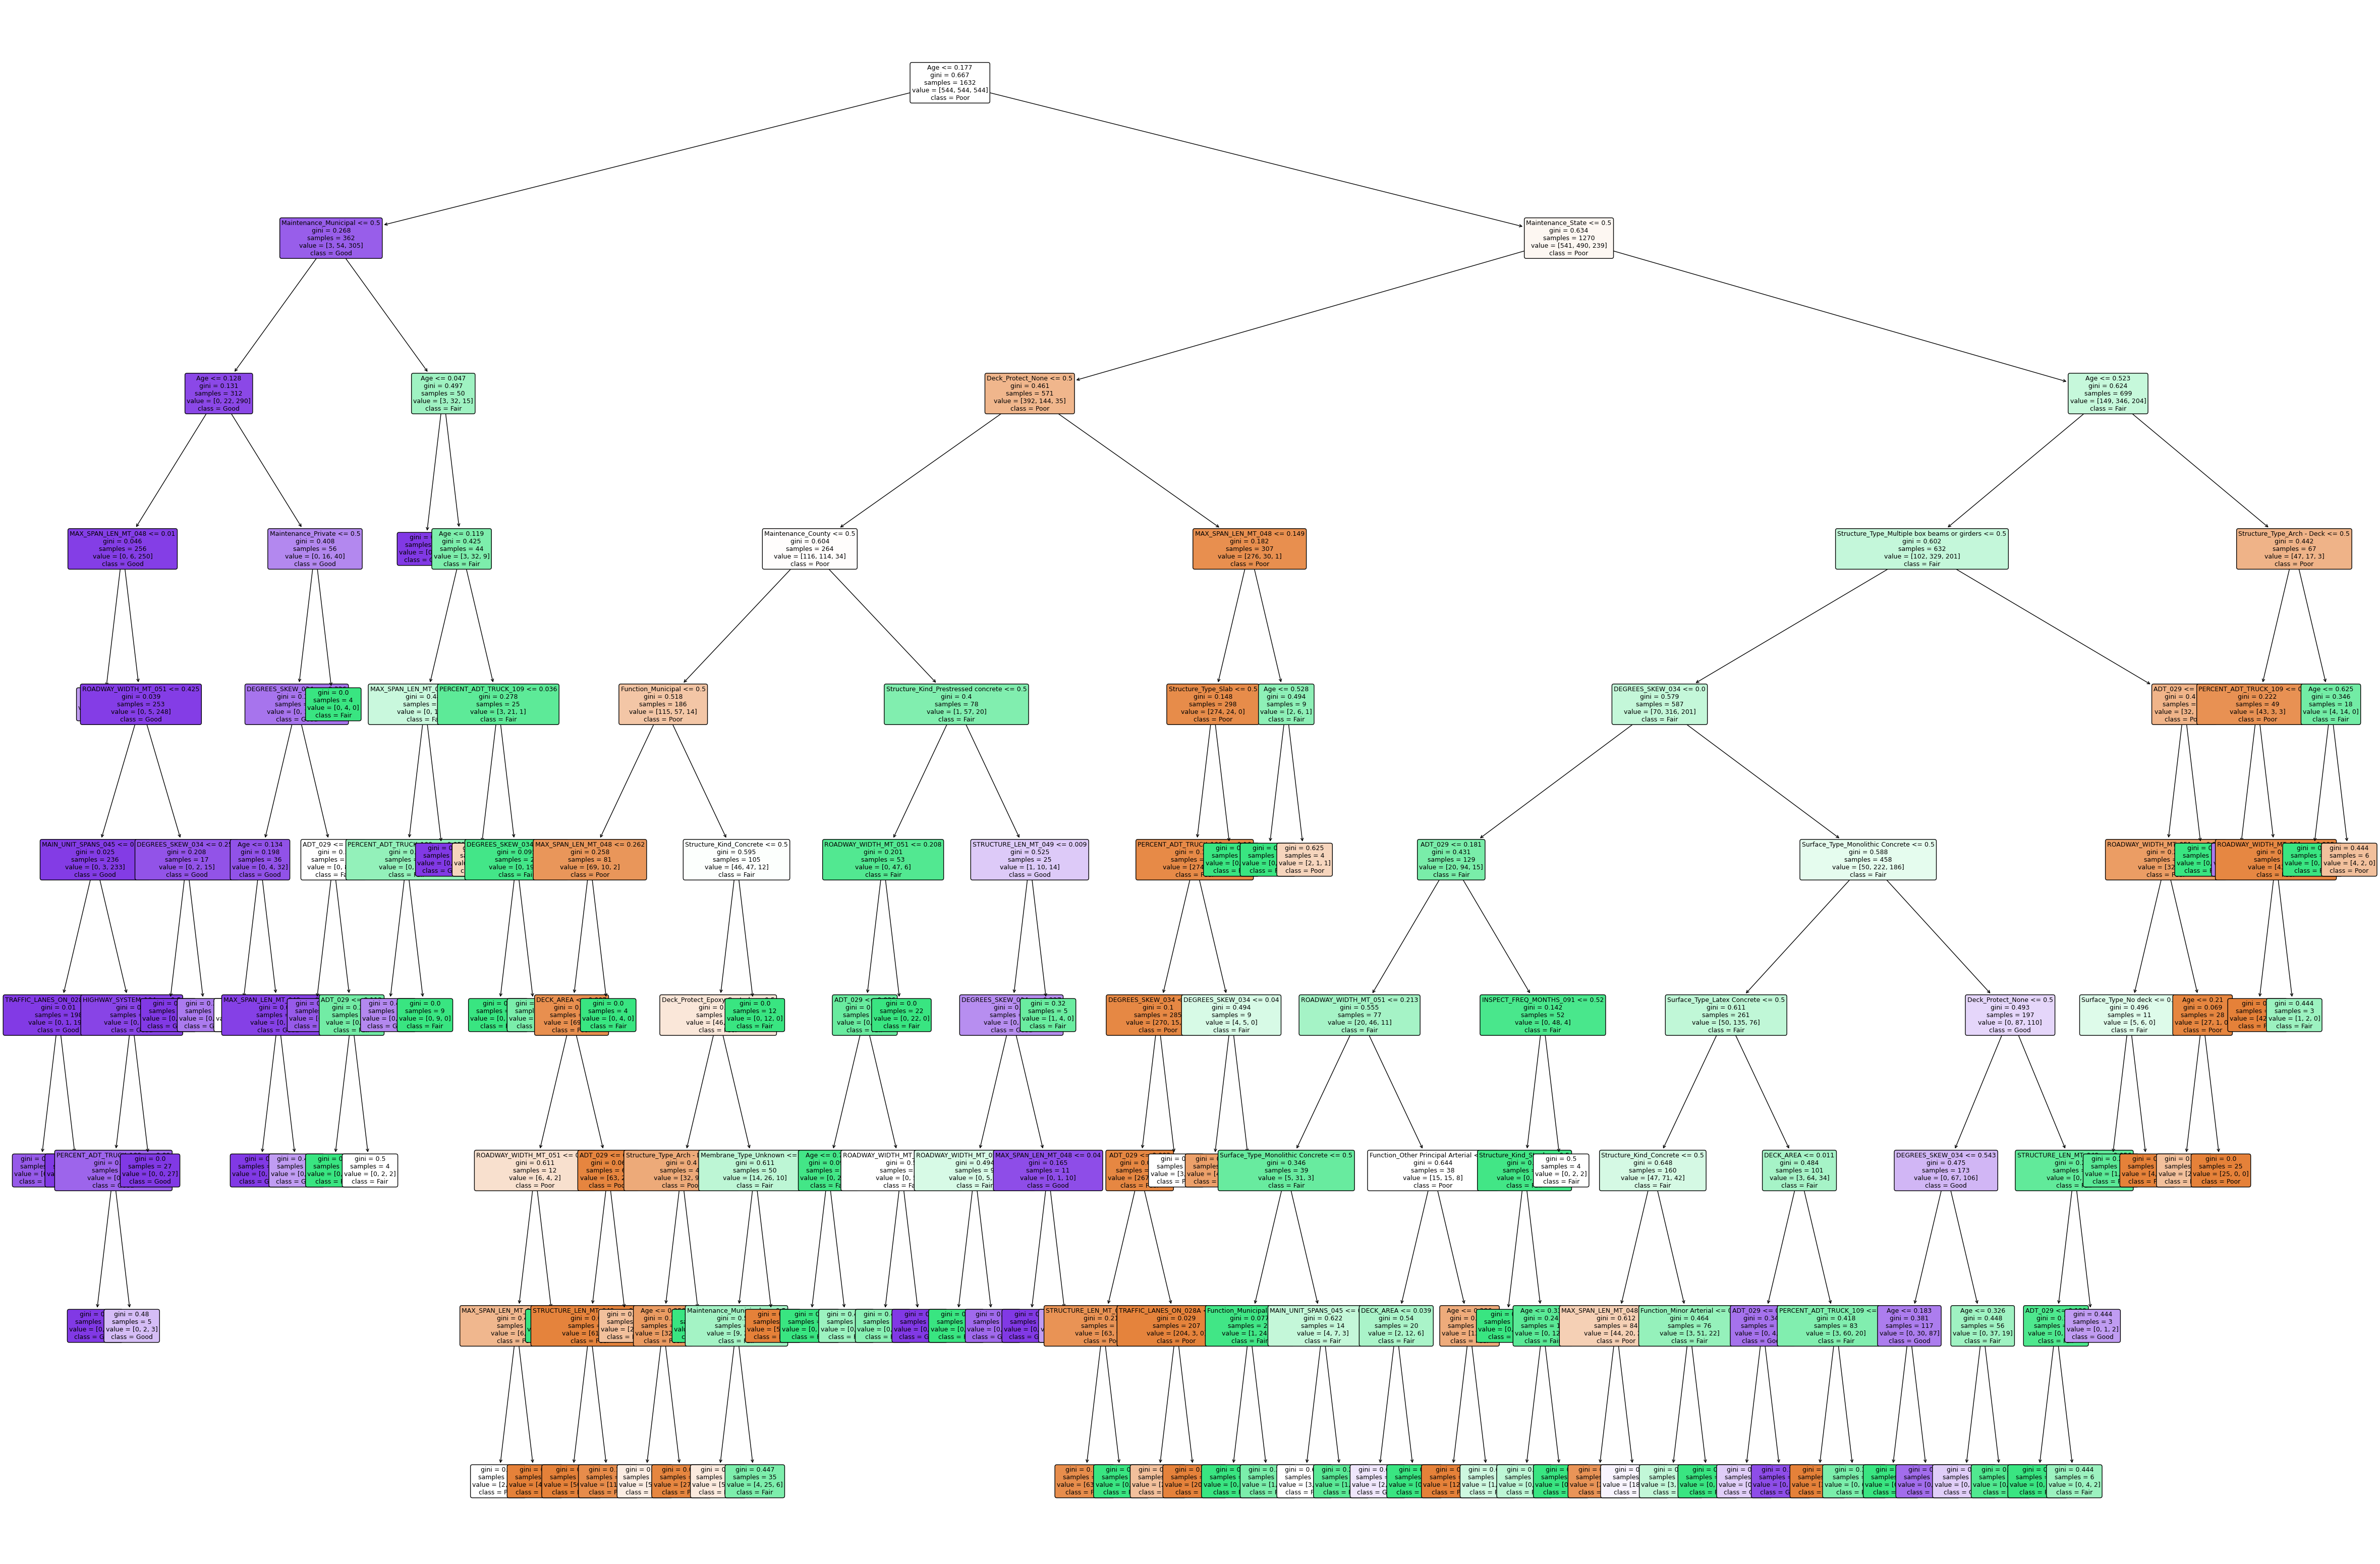

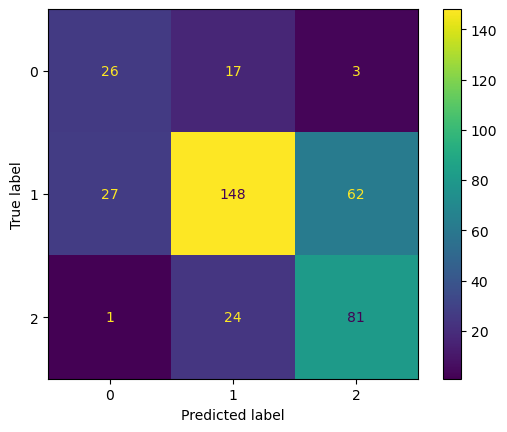

In [16]:
evaluate_CART(df)

## 3.3 Logistic Regression

In [17]:
def evaluate_logisticregression(df):
    y = df.loc[:, df.columns =='BRIDGE_CONDITION']
    X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    columns = X_train.columns
    #oversampling with SMOTE
    oversample = SMOTE()
    os_data_X,os_data_y=oversample.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(data=os_data_X,columns=columns)
    y_train= pd.DataFrame(data=os_data_y,columns=['BRIDGE_CONDITION'])
    logbridge = LogisticRegression()
    logbridge.fit(X_train, y_train)
    y_pred = logbridge.predict(X_test)
    #print(y_pred)
    lr_accuracy = accuracy_score(y_test, y_pred)
    print('Logistic Regression Accuracy of Scikit Model: {:.3f}%'.format(lr_accuracy*100))
    cm_bridge = confusion_matrix(y_test,y_pred)
    #print(cm_bridge)
    print(classification_report(y_test, y_pred, digits=3))
    display_cm_bridge= ConfusionMatrixDisplay(confusion_matrix=cm_bridge, 
                                              display_labels=['Poor (0)',
                                                              'Fair (1)',
                                                             'Good (2)'])
    display_cm_bridge.plot()
    
#Should we add cross-validation to this?

Logistic Regression Accuracy of Scikit Model: 69.923%
              precision    recall  f1-score   support

           0      0.532     0.543     0.538        46
           1      0.783     0.700     0.739       237
           2      0.623     0.764     0.686       106

    accuracy                          0.699       389
   macro avg      0.646     0.669     0.654       389
weighted avg      0.710     0.699     0.701       389



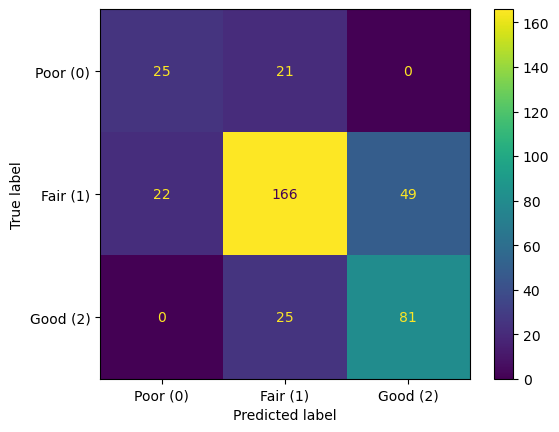

In [18]:
evaluate_logisticregression(df)

Our accuracy is slightly worse than the CART model, but not by much, suggesting that the logistic regression is an okay fit at predicting bridge condition. We can see that the model is much worse at predicting poor bridge conditions that fair or good conditions, likely a result of the amount of data we have on poor bridges. 

# Bridge Data with Demographic and socioeconomic variables 


In [19]:
df2 = pd.read_csv('df2.csv')

                             Feature  Importance
15                               Age    0.096558
79         Deck_Protect_Epoxy Coated    0.072456
86               Original_row_number    0.052827
0                              index    0.046635
7               ROADWAY_WIDTH_MT_051    0.041555
20                 Maintenance_State    0.037069
68  Surface_Type_Monolithic Concrete    0.028818
82                 Deck_Protect_None    0.027444
30           Structure_Kind_Concrete    0.026547
6               STRUCTURE_LEN_MT_049    0.022876
The best parameters are {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 100} 

Accuracy score for test data is: 0.686
Accuracy score for train data is: 0.957

Classification Report: 
 
               precision    recall  f1-score   support

           0       0.54      0.45      0.49        31
           1       0.75      0.76      0.75       137
           2       0.60      0.63      0.62        52

    accuracy                           0.69     

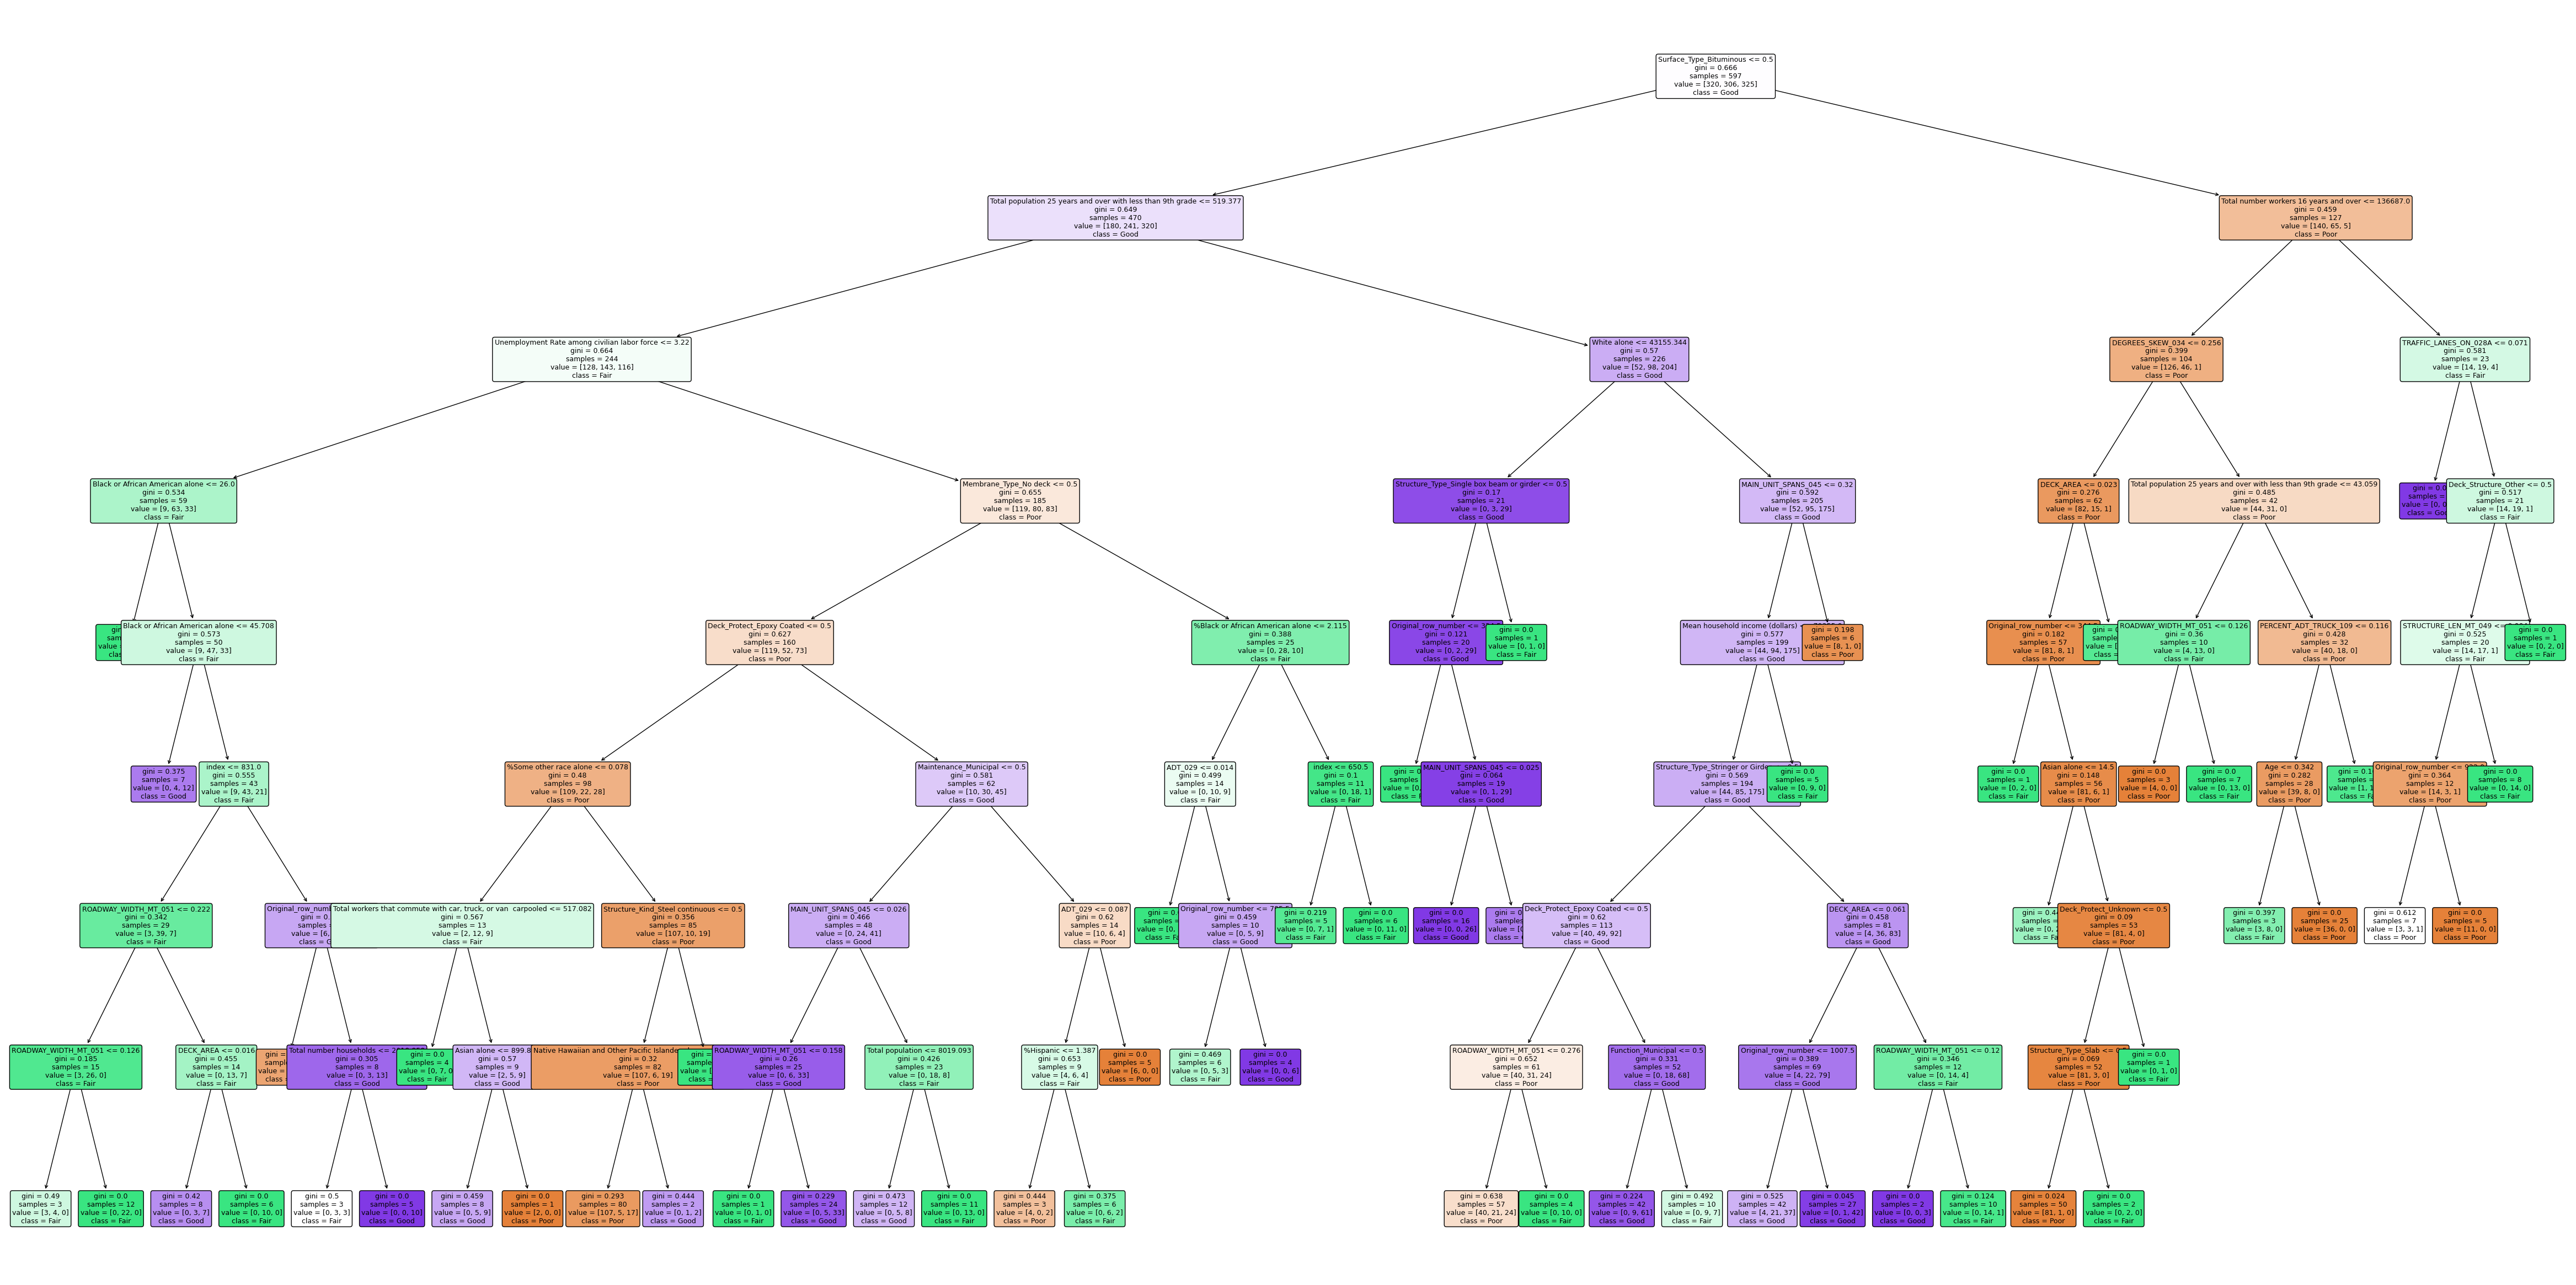

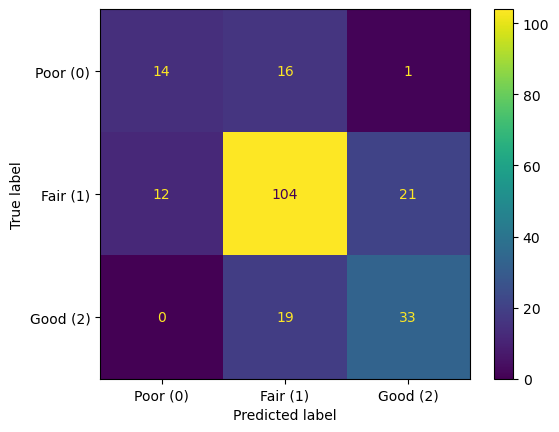

In [20]:
evaluate_randomforrest(df2)

The best parameters found are: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 9} 

                      Feature  Importance
15                        Age    0.248886
9          HIGHWAY_SYSTEM_104    0.143305
3            DEGREES_SKEW_034    0.082503
80  Deck_Protect_Epoxy Coated    0.073288
17      Maintenance_Municipal    0.050671
2                     ADT_029    0.040257
70       Surface_Type_No deck    0.040214
83          Deck_Protect_None    0.033072
87        Original_row_number    0.030496
6        STRUCTURE_LEN_MT_049    0.028983
Accuracy score for test data is: 0.656
Accuracy score for train data is: 0.901

Classification Report 
               precision    recall  f1-score   support

           0       0.31      0.63      0.41        19
           1       0.73      0.67      0.70       157
           2       0.68      0.64      0.66       103

    accuracy                           0.66       279
   macro avg       0.57      0.65      0.

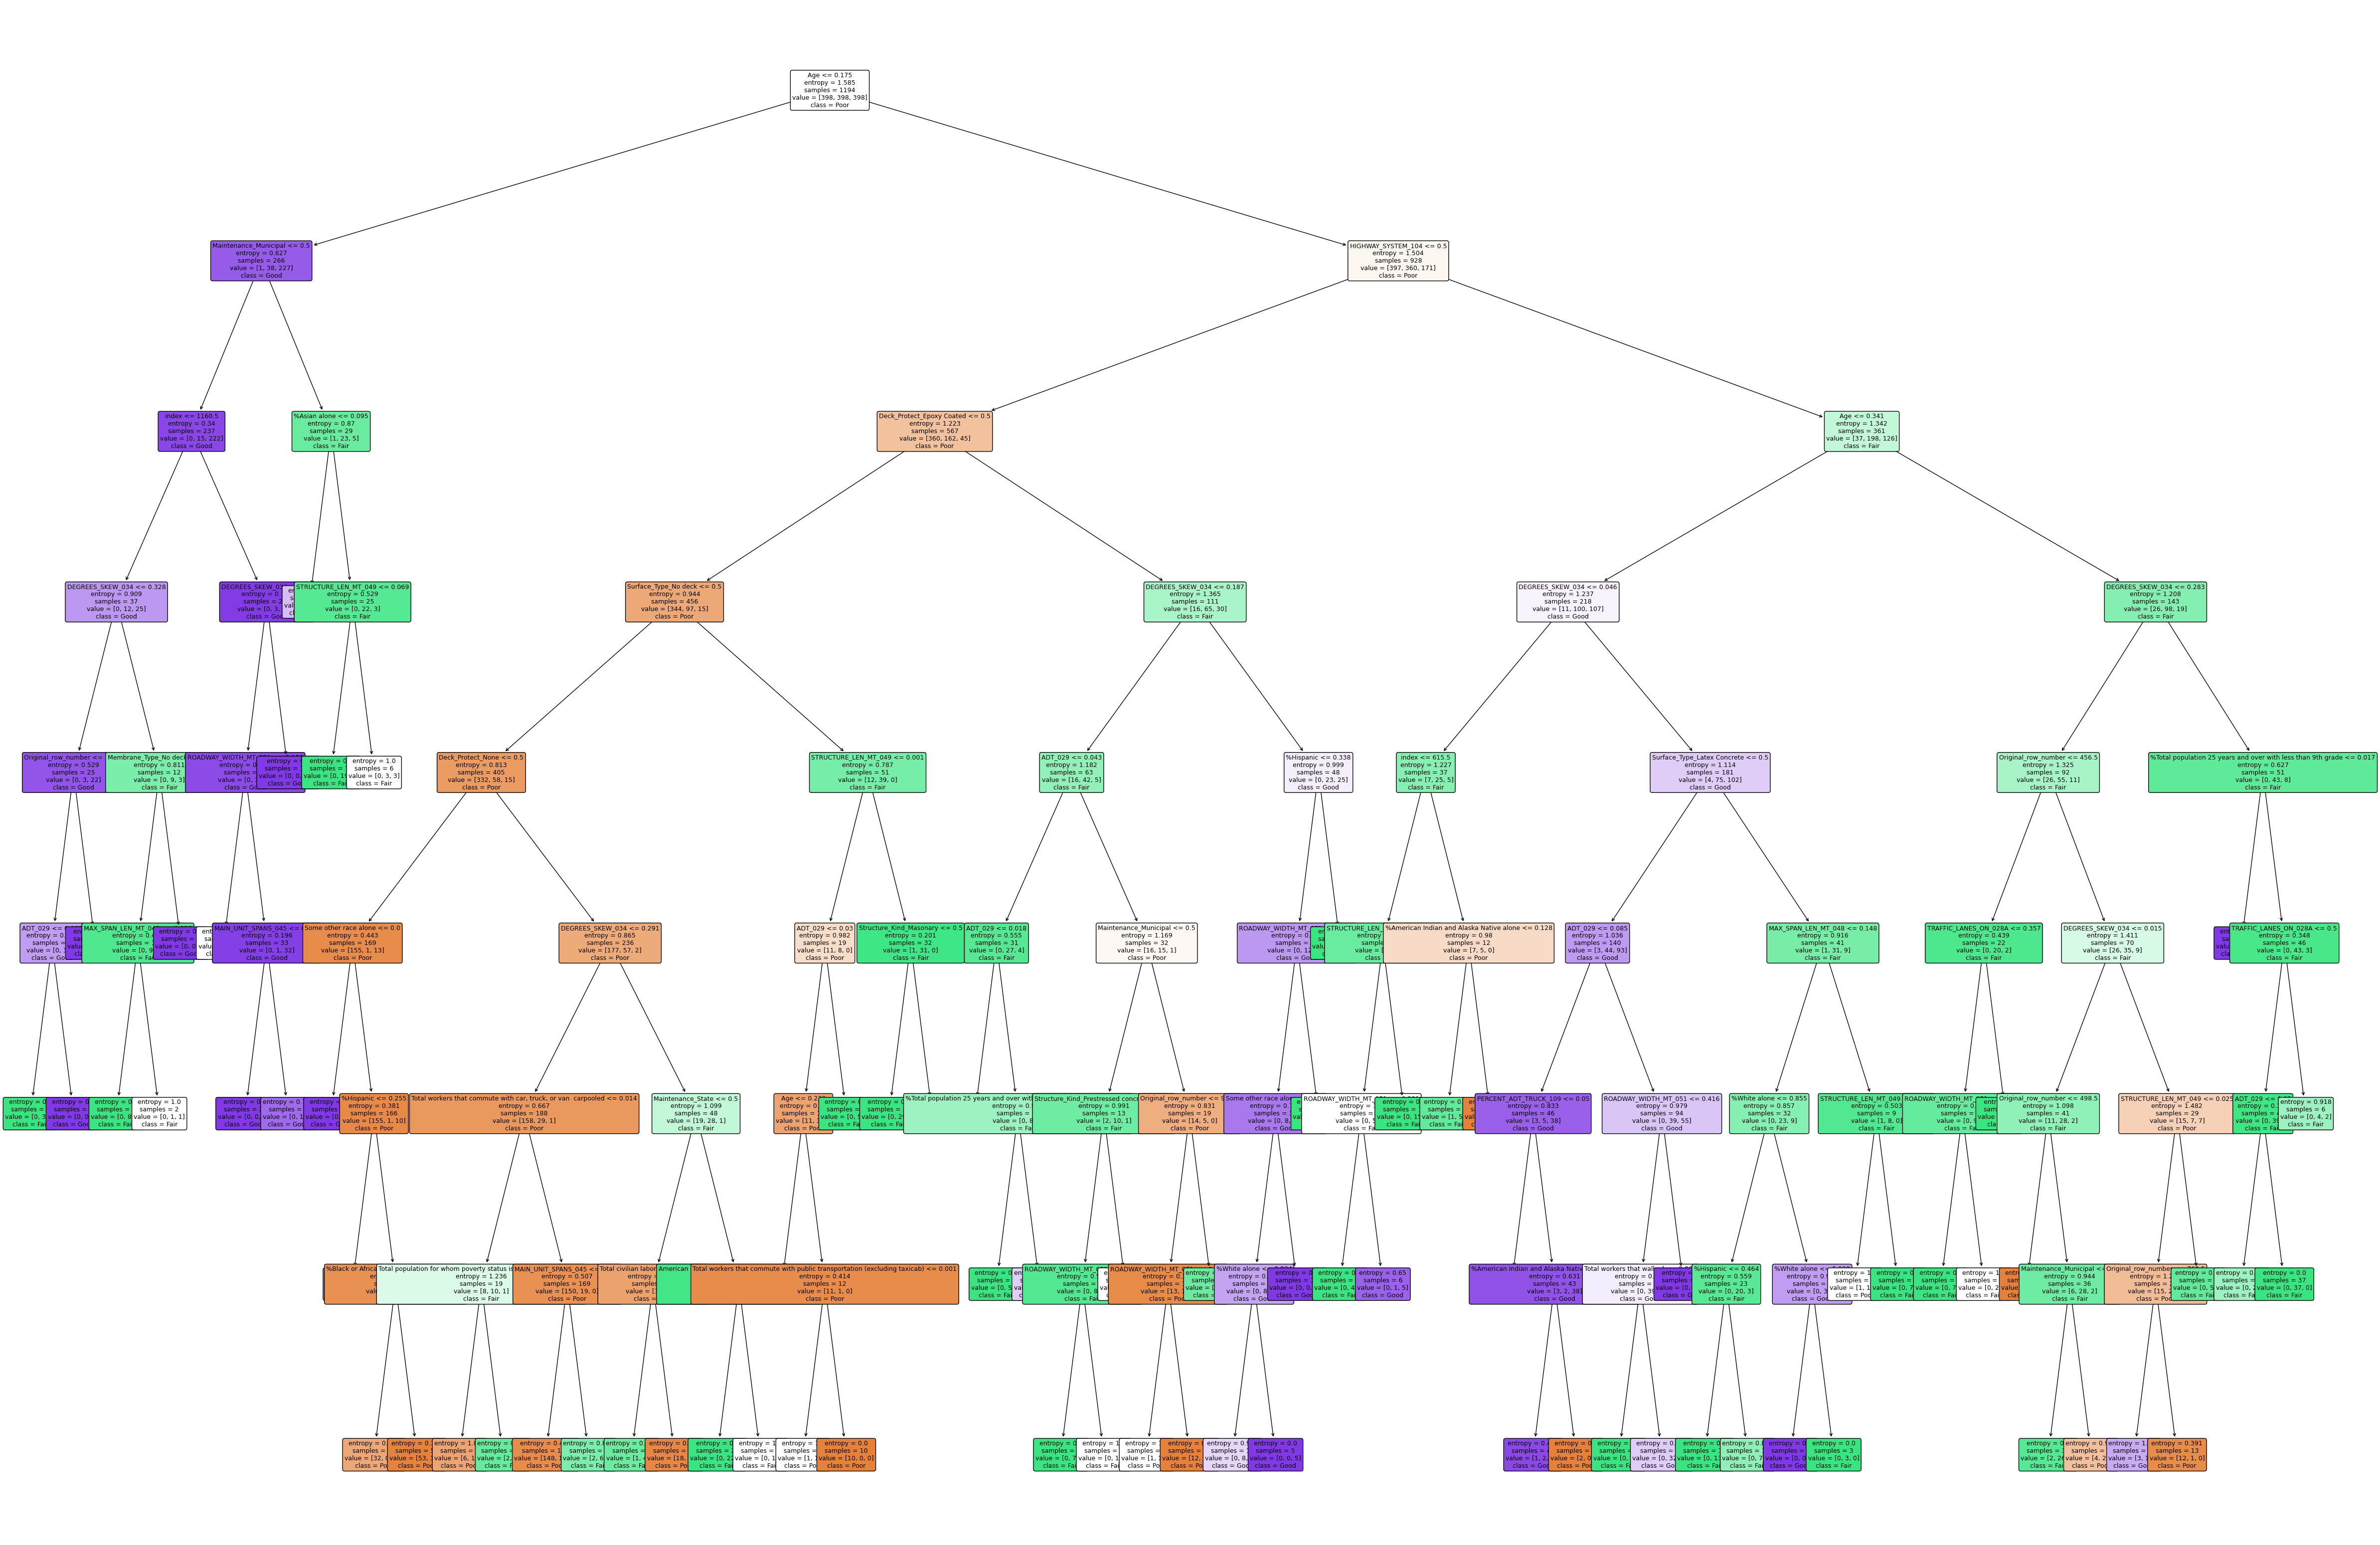

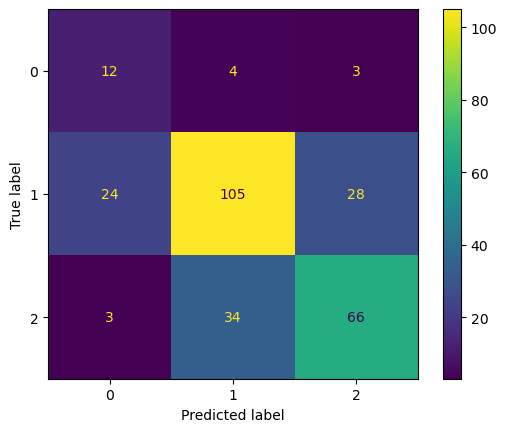

In [139]:
evaluate_CART(df2)

Logistic Regression Accuracy of Scikit Model: 69.892%
              precision    recall  f1-score   support

           0      0.353     0.632     0.453        19
           1      0.727     0.764     0.745       157
           2      0.787     0.612     0.689       103

    accuracy                          0.699       279
   macro avg      0.623     0.669     0.629       279
weighted avg      0.724     0.699     0.704       279



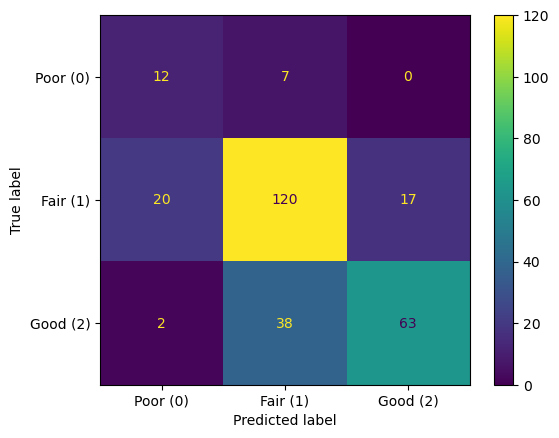

In [140]:
evaluate_logisticregression(df2)